# Оптимизация маркетинговых затрат в Яндекс Афише

Необходимо расчитать основные метрики, найти показатели, которые возможно изменить для улучшения приложения


1. [Открытие исходных данных](#start)


2. [Изучение данных и проверка типов на корректность](#preprocessing)
    

3. [Предобработка](#date)


4. [Расчет продуктовых метрик](#metrics)
   * [Количество пользователей](#users)
   * [Количество ссесий в день](#daysession)
   * [Длительность сессий](#timesession)
   * [Частота возврата пользователей](#frequency)


5. [Расчет бизнес метрик](#businessmetrics)
   * [Время покупок](#timeorder)
   * [Количество покупок за период](#byus)
   * [Средний чека](#check)
   * [Расчет LTV](#LTV)
   

6. [Расчет маркетиговых показателей](#marketing)
   * [Расчет потраченных денег](#pursch)
   * [Стоимость привлечения 1 покупателя](#cost)
   * [Расчет ROI](#ROI)


6. [Заключение. Общий вывод](#resume)

# Открытие исходных даных
<a id="start"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from termcolor import colored


In [2]:
try:
    visits_log = pd.read_csv('e:/Home/datasets/visits_log.csv')
    orders_log = pd.read_csv('e:/Home/datasets/orders_log.csv')
    costs = pd.read_csv('e:/Home/datasets/costs.csv')
except:
    visits_log = pd.read_csv('/datasets/visits_log.csv')
    orders_log = pd.read_csv('/datasets/orders_log.csv')
    costs = pd.read_csv('/datasets/costs.csv') 

# Изучение данных и проверка типов на корректность
<a id="preprocessing"></a>

In [3]:
visits_log.sample(3)

,Device,End Ts,Source Id,Start Ts,Uid
252408,touch,2018-03-05 23:34:00,4,2018-03-05 23:26:00,408503457715082114
243419,desktop,2018-05-08 15:27:00,4,2018-05-08 15:25:00,9602464566270845651
190293,desktop,2017-09-29 09:41:00,3,2017-09-29 09:39:00,228379563587210523


In [4]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
visits_log.nunique()

Device            2
End Ts       224760
Source Id         9
Start Ts     224303
Uid          228169
dtype: int64

Посмотрим уникальные имена признаков наименования устройств и источников поступления информации

In [6]:
s = ['Device','Source Id']
for col in s:
    print(visits_log[col].sort_values().unique())

['desktop' 'touch']
[ 1  2  3  4  5  6  7  9 10]


In [7]:
visits_log.isnull().sum()

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [8]:
visits_log.duplicated().sum()

0

Пропусков нет, дубликатов нет,  приведение к регистру не нужно, типы данных корректные для соотвествующих данных, кроме времени старта и конца сессии. Необходимо преобразование в типу datetime

In [9]:
orders_log.sample(3)

,Buy Ts,Revenue,Uid
25307,2017-12-21 22:25:00,5.87,9683822093920383077
32541,2018-02-02 09:28:00,1.22,383168223736428939
30927,2018-01-25 08:41:00,3.36,7450055960085201040


In [10]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [11]:
orders_log.isnull().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [12]:
orders_log.duplicated().sum()

0

In [13]:
orders_log.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


Пропусков нет, дубликатов нет,  приведение к регистру или переименовывание не нужно, типы данных корректны, кроме  времени покупки, требуется преобразование типа

In [14]:
costs.sample(3)

,source_id,dt,costs
210,1,2017-12-28,40.70
1750,5,2018-03-26,241.36
464,2,2017-09-10,80.49


In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [16]:
costs.isnull().sum()

source_id    0
dt           0
costs        0
dtype: int64

In [17]:
costs.duplicated().sum()

0

In [18]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


Пропусков нет, дубликатов нет, для удобства необхоимо приведение к регистру и удаление пробелов в названии признаков, типы данных корректны, кроме даты покупки, требуется преобразование типа. В предобработке посмотрим на корректность времен - что время окончания действия указаны более поздние, чем время начала совершения действия, а также что время покупки больше времени старта сессии и менее времени окончания сессии

# Предобработка
<a id="date"></a>

Удаление пробелов, приведение к нижнему регистру названий признаков. Преобразование в типу datetime

In [19]:
visits_log.columns = visits_log.columns.str.replace(' ', '_')
visits_log.columns = visits_log.columns.str.lower()
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [20]:
costs.columns = costs.columns.str.replace(' ', '_')
costs.columns = costs.columns.str.lower()
costs['date'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [21]:
orders_log.columns = orders_log.columns.str.replace(' ', '_')
orders_log.columns = orders_log.columns.str.lower()
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'], format='%Y-%m-%d %H:%M:%S')

проверка того, что даты начала действия менее даты окончание, удаление таких строк

In [22]:
visits_log.query('start_ts > end_ts')

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


У двух пользователей есть две сессии, где время окончания менее старта сессии. Возможно ошибка выгрузки

# Расчет продуктовых метрик
<a id="metrics"></a>

Выделение даты, года, месяца, дня из переменной типа datetime

In [23]:
visits_log['session_year'] = visits_log['start_ts'].dt.year
visits_log['session_month'] = visits_log['start_ts'].dt.month 
visits_log['session_week'] = visits_log['start_ts'].dt.week 
visits_log['date'] = visits_log['start_ts'].dt.date 
visits_log[:1]

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20


In [24]:
orders_log['buy_year'] = orders_log['buy_ts'].dt.year
orders_log['buy_month'] = orders_log['buy_ts'].dt.month 
orders_log['buy_week'] = orders_log['buy_ts'].dt.week
#orders_log['date'] = orders_log['buy_ts'].dt.date
orders_log[:1]

,buy_ts,revenue,uid,buy_year,buy_month,buy_week
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017,6,22


### Расчет количества пользователей
<a id="users"></a>

In [25]:
# Группировка по дате сессии, агрегация по uid, подсчет среднего, расчет
# DAU
# WAU
# MAU
list_sess_date = []
dau_total = int( \
                visits_log \
                .groupby('date') \
                .agg({'uid': 'nunique'}) \
                .mean())
list_sess_date.append(dau_total)     


wau_total = int( \
                visits_log \
                .groupby(['session_year', 'session_week']) \
                .agg({'uid': 'nunique'}) \
                .mean())
list_sess_date.append(wau_total)

mau_total = int( \
                visits_log \
                .groupby(['session_year', 'session_month']) \
                .agg({'uid': 'nunique'}) \
                .mean())
list_sess_date.append(mau_total)

Общее число сессий и пользователей

In [26]:
sessions_per_user = visits_log  \
                        .groupby(['session_year', 'session_month']) \
                        .agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']

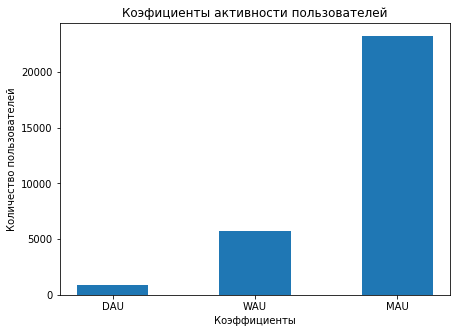

In [27]:
# диаграмма числа уникальных пользователей в ДЕНЬ. НЕДЕЛЯ, МЕСЯЦ
groups = ['DAU', 'WAU', 'MAU']
plt.figure(figsize=(7, 5));
plt.bar(groups, list_sess_date, width = 0.5);
plt.title("Коэфициенты активности пользователей");
plt.ylabel('Количество пользователей');
plt.xlabel('Коэффициенты');

Среднее количество пользователей с уникальными uid растет со временем, необходимо детально посмотреть по месяцам

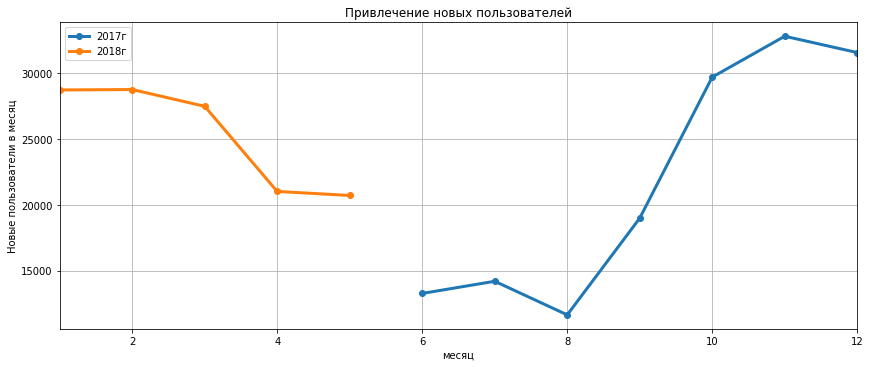

In [28]:
(sessions_per_user
     .pivot_table(index='session_month', columns='session_year',aggfunc={'n_users':sum})
     .plot( y='n_users', figsize=(12, 5), grid=True, marker = 'o',linewidth = 3)
) ;
plt.tight_layout();
plt.title("Привлечение новых пользователей");
plt.legend(["2017г", "2018г"]);
plt.xlabel("месяц");
plt.ylabel("Новые пользователи в месяц");

### Расчет количества сессий за период
<a id="daysession"></a>

Количество сессий в среднем одного пользователя

In [29]:

sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user[:2]

n_sessions  n_users  sessions_per_user
session_year session_month                                        
2017         6                   16505    13259           1.244815
             7                   17828    14183           1.256998

In [30]:
sessions_per_user['sessions_per_user'].mean()

1.2808894945992668

###### В среднем один пользователь проводит не более 2 сессий в месяц

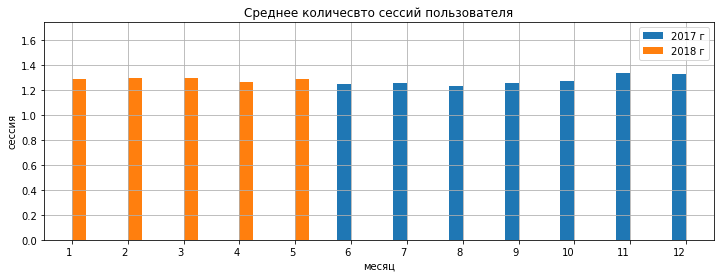

In [31]:
ax =  (sessions_per_user
           .pivot_table(index='session_month', columns=['session_year'])
           .plot(kind='bar', y='sessions_per_user', figsize=(12, 4), \
           grid=True,  ylim=(0, 1.3*sessions_per_user['sessions_per_user'].max()), \
           linewidth=2))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right');
ax.set_title('Среднее количесвто сессий пользователя');
ax.set_ylabel('сессия');
ax.set_xlabel('месяц');
ax.legend(["2017 г", "2018 г"]);

Количесвто сессий со временем изменяется несущественно и колеблется возле среднего. Наблюдается неольшой рост числа сессий одного пользователя к концу года. Начало следующего года небольшой спад


### Расчет длительности сессий
<a id="timesession"></a>

продолжительность сессии в среднем для одного пользователя

In [32]:
visits_log['session_duration_sec'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds
"{:.2f} сек.".format(visits_log['session_duration_sec'].mean())

'643.51 сек.'

ASL = 643.51. Тем не менее, половина всех сессий короче 300с. 

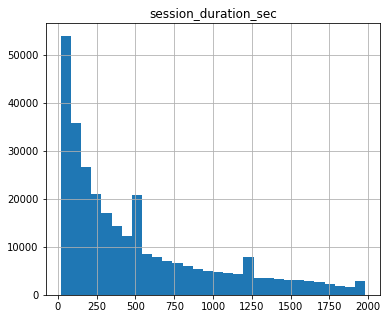

In [33]:
visits_log \
    .query('10 < session_duration_sec < 2000') \
    .hist(column = 'session_duration_sec', bins = 30, figsize=(6,5)); 

In [34]:
visits_log['session_duration_sec'].value_counts().head(1)

60    53029
Name: session_duration_sec, dtype: int64

Наиболее часто сессия длится в среднем 60с

### Расчет частоты возврата пользователей
<a id="frequency"></a>

In [35]:
first_activity_date = visits_log.groupby(['uid'])['start_ts'].min().astype('datetime64[M]')
first_activity_date.name = 'first_activity_date'
#first_activity_date['first_activity_date'] = pd.to_datetime(first_activity_date['first_activity_date']).dt.date

visits_log = visits_log.join(first_activity_date,on='uid') 
visits_log['activity_month'] = \
                pd.to_datetime(visits_log['start_ts']) \
                - pd.to_timedelta(visits_log['start_ts'].dt.week)
visits_log['first_activity_month'] = pd.to_datetime(visits_log['first_activity_date']) \
                                    - pd.to_timedelta(visits_log['first_activity_date'].dt.week) 
visits_log['cohort_lifetime'] = visits_log['activity_month'] - visits_log['first_activity_month']
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'] / np.timedelta64(1,'M')
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'].astype('int') 

cohorts = visits_log \
                .groupby(['first_activity_month','cohort_lifetime']) \
                .agg({'uid':'nunique'}) \
                .reset_index() 
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count,on='first_activity_month') 
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
retention_pivot=cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum') 

Нарисуем тепловую карту

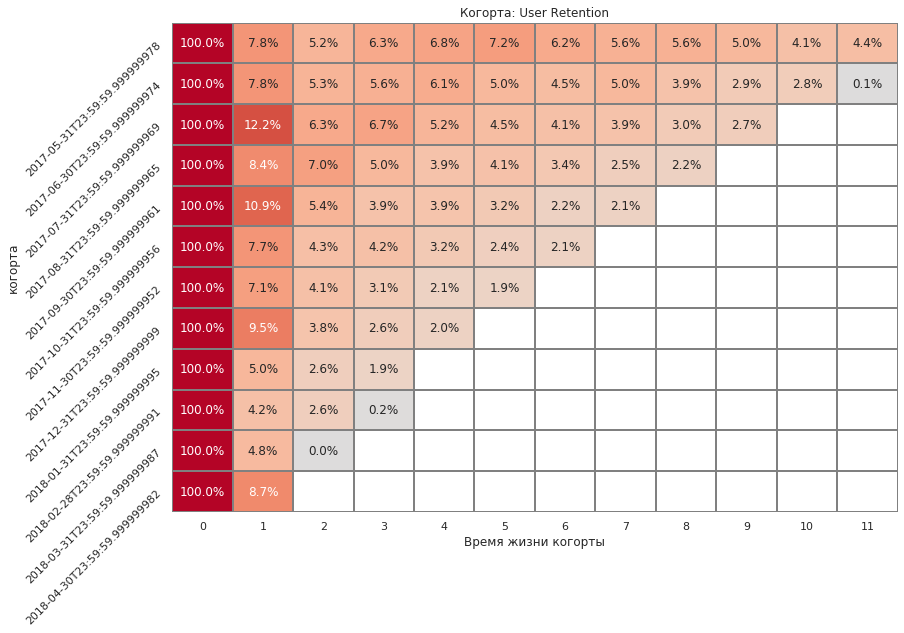

In [36]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(retention_pivot \
            ,annot=True \
            ,fmt='.1%' \
            ,linewidths=1 \
            ,linecolor='gray' \
            ,vmin=0 \
            ,vmax=0.15 \
            ,center= 0 \
            ,cmap='coolwarm' \
            ,cbar=False);

plt.title('Когорта: User Retention')
plt.xlabel("Время жизни когорты");
plt.ylabel("когорта");
plt.yticks(rotation=45);
plt.xticks(rotation=0);


Количество отсавшихся пользователей в кагорте, но не по сессии, а по покупкам

In [37]:
first_order_date_by_customers = orders_log.groupby('uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'
orders = orders_log.join(first_order_date_by_customers,on='uid')
orders_log['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders_log['order_month'] = orders_log['buy_ts'].astype('datetime64[M]')

orders_log.pivot_table(index='first_order_month',
    columns='order_month',
    values='uid',
    aggfunc='nunique').fillna('')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,2023,61,50,54,88,67,62,47,58,45,45,53,
2017-07-01,,1923,52,57,64,49,38,36,39,42,22,26,
2017-08-01,,,1370,58,53,44,40,32,30,44,19,31,
2017-09-01,,,,2581,130,100,74,52,64,66,37,43,
2017-10-01,,,,,4340,206,123,92,93,72,56,67,
2017-11-01,,,,,,4081,222,120,106,81,48,62,
2017-12-01,,,,,,,4383,146,103,97,50,63,
2018-01-01,,,,,,,,3373,114,83,43,45,
2018-02-01,,,,,,,,,3651,118,58,39,


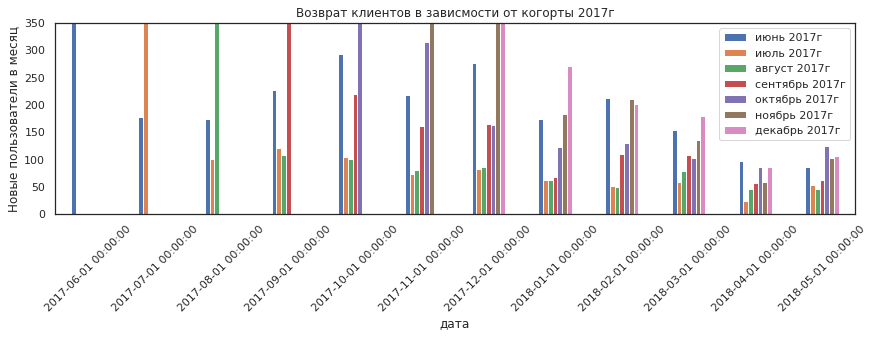

In [38]:
(orders_log.query('first_order_month < "2018-01-01"') \
     .pivot_table(index='order_month', columns='first_order_month', aggfunc='count') \
     .plot(kind='bar',y='uid' \
           ,figsize=(12, 5)) \
           #,grid=True \
           #,marker = 'o' \
           #,linewidth = 3) \
) ;
plt.tight_layout();
plt.title("Возврат клиентов в зависмости от когорты 2017г");
plt.legend(["июнь 2017г", "июль 2017г", "август 2017г", "сентябрь 2017г", \
            "октябрь 2017г", "ноябрь 2017г", "декабрь 2017г"]);
plt.xlabel("дата");
plt.ylabel("Новые пользователи в месяц");
plt.ylim(ymax=350, ymin=0);
plt.xticks(rotation=45);

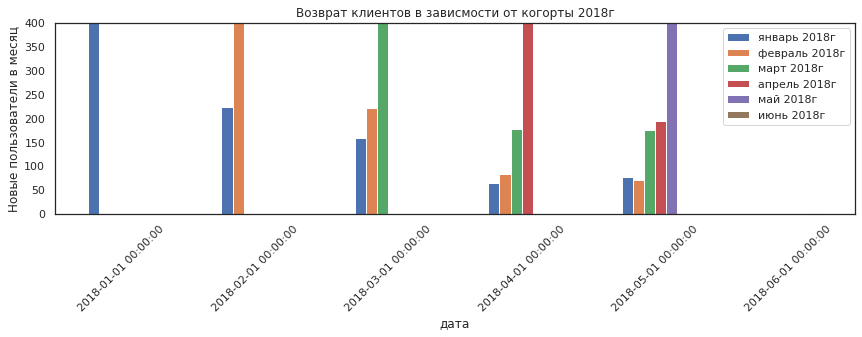

In [39]:
(orders_log.query('first_order_month > "2017-12-01"') \
     .pivot_table(index='order_month', columns='first_order_month', aggfunc='count') \
     .plot(kind='bar', y='uid' \
           ,figsize=(12, 5)) \
           #,marker = 'o' \
           #,linewidth = 3) \
) ;
plt.tight_layout();
plt.title("Возврат клиентов в зависмости от когорты 2018г");
plt.legend(["январь 2018г", "февраль 2018г", "март 2018г", "апрель 2018г", "май 2018г", "июнь 2018г"]);
plt.xlabel("дата");
plt.ylabel("Новые пользователи в месяц");
plt.ylim(ymax=400, ymin=0);
plt.xticks(rotation=45);

В целом наблюдается сильное снижение возврата пользователей после первого месяца. Ввиду малого периода времени пользователей пришедших после мая 2018 трудно сделать вывод.    В некоторых когортах ( июнь 2017) число покупателей периодически начинает расти осенью 2017, в основном плавное снижение численности до конца года. Количество покупателей уменьшается во всех когортах в декабре 2017.    В мае 2018 наблюдаеся всплеск активности пользователей по всем когорт 2017, в отличие от когорт 2018., где наблюдается падение активности.


# Расчет бизнес метрик 
<a id="businessmetrics"></a>

### Расчет времени покупок
<a id="timeorder"></a>

Выделим время старта сессии, смержим по uid с данными о покупках, найдем разницу между временем покупи и началом сессии

In [40]:
first_session_date = visits_log.groupby('uid',as_index=False)['start_ts'].min()
first_session_date.rename(columns = {'start_ts':'first_session_date'},inplace = True)
order_time = orders_log.merge(first_session_date,on='uid', how='inner')

In [41]:
order_time[:2]

,buy_ts,revenue,uid,buy_year,buy_month,buy_week,first_order_month,order_month,first_session_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,6,22,2017-06-01,2017-06-01,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,6,22,2017-06-01,2017-06-01,2017-06-01 00:14:00


In [42]:
order_time['time_delay_sec'] = (order_time['buy_ts'] - order_time['first_session_date']).dt.seconds
order_time['time_delay_sec'].value_counts().head(3)

60     2687
0      2486
120    2142
Name: time_delay_sec, dtype: int64

Из тех кто покупает, наиболее часто покупают через 60 с после начала первой сессии

Время от начала первой сессии до покупки внутри каждой кагорты в среднем

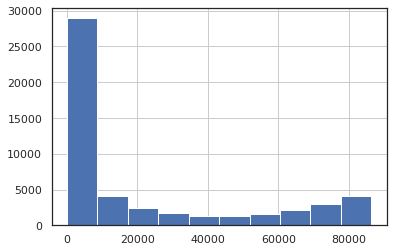

In [43]:
order_time['time_delay_sec'].hist();

In [44]:
order_time.pivot_table(index='first_order_month',
    columns='order_month',
    values='time_delay_sec',
    aggfunc='median').fillna('')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,600,23580,21810,22860,21510,24270,19590,20100,21120,23400,29970,38580,
2017-07-01,,780,51720,56070,44910,50220,62880,47280,26850,54360,57330,68880,
2017-08-01,,,720,48780,43320,39120,67500,48180,46620,28440,65340,45870,
2017-09-01,,,,1020,46200,30660,25980,46320,41040,49980,28080,66660,
2017-10-01,,,,,1140,35490,33660,41640,47280,54060,39810,40320,
2017-11-01,,,,,,2700,49680,34740,31560,39720,46440,39450,
2017-12-01,,,,,,,2340,58230,60810,62520,58560,31140,
2018-01-01,,,,,,,,1920,35640,32340,35310,26670,
2018-02-01,,,,,,,,,1800,39510,50940,26280,


### Расчет количества покупок за период
<a id="buys"></a>

In [45]:
first_purchase_dates = orders_log.groupby('uid')['buy_ts'].min()
first_purchase_dates.name = 'first_purchase_datetime'
report = orders_log.join(first_order_date_by_customers,on='uid')
report['first_order_month'] = report['first_order_date'].astype('datetime64[M]')
report['order_month'] = report['buy_ts'].astype('datetime64[M]')
purchase_grouped_by_cohorts = report.groupby(['first_order_month','order_month']).agg({'buy_ts':'count','uid':'nunique'})

In [46]:
purchase_grouped_by_cohorts['quont_purchase_per'] = purchase_grouped_by_cohorts['buy_ts']/purchase_grouped_by_cohorts['uid']

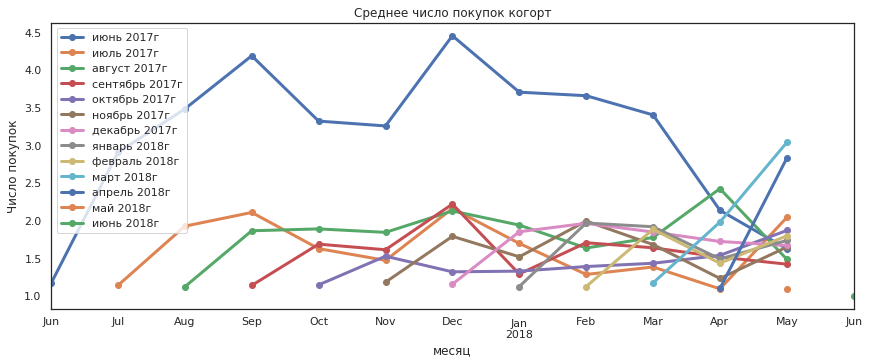

In [47]:
(purchase_grouped_by_cohorts \
         .pivot_table(index='order_month', columns='first_order_month')
         .plot( \
               y='quont_purchase_per' \
               ,figsize=(12, 5) \
               ,marker = 'o' \
               ,linewidth = 3)
) ;
plt.tight_layout();
plt.title("Среднее число покупок когорт");
plt.legend(["июнь 2017г", "июль 2017г", "август 2017г", "сентябрь 2017г", \
            "октябрь 2017г", "ноябрь 2017г", "декабрь 2017г", \
            "январь 2018г", "февраль 2018г", "март 2018г", "апрель 2018г", "май 2018г", "июнь 2018г"]);
plt.xlabel("месяц");
plt.ylabel("Число покупок");

Первая когорта покупает чаще всех. У когорт март-апрель 2018 более резкий рост числа покупок, чем у остальных

### Средний чек
<a id="chesk"></a>

In [48]:
first_order_date_by_customers = orders_log.groupby('uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'
orders_log = orders_log.join(first_order_date_by_customers,on='uid')
orders_log['first_order_month'] = orders_log['first_order_date'].astype('datetime64[M]')
orders_log['order_month'] = orders_log['buy_ts'].astype('datetime64[M]')
orders_grouped_by_cohorts = orders_log \
                    .groupby(['first_order_month','order_month']) \
                    .agg({'revenue':'sum','uid':'nunique'})

In [49]:
#orders_grouped_by_cohorts.reset_index().sample(2)
orders_grouped_by_cohorts[:2]

revenue   uid
first_order_month order_month               
2017-06-01        2017-06-01   9557.49  2023
                  2017-07-01    981.82    61

Cредний чек

In [50]:
orders_grouped_by_cohorts['revenue_per_user'] \
            = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts.sample(4)

,,revenue,uid,revenue_per_user
first_order_month,order_month,,,
2018-05-01,2018-05-01,13925.76,2988,4.660562
2017-06-01,2017-12-01,1922.74,62,31.011935
2017-09-01,2017-12-01,10261.52,74,138.669189
2017-06-01,2018-04-01,1155.66,45,25.681333


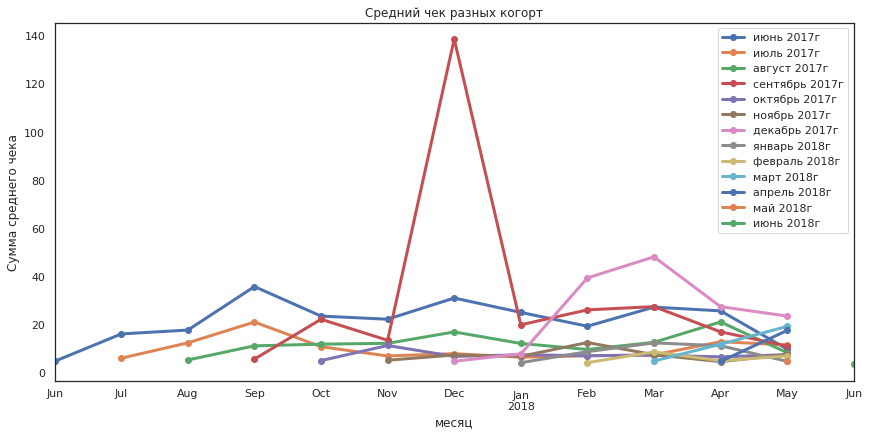

In [51]:
(orders_grouped_by_cohorts \
         .pivot_table(index='order_month', columns='first_order_month')
         .plot( \
               y='revenue_per_user' \
               ,figsize=(12, 6) \
               ,marker = 'o' \
               ,linewidth = 3)
) ;
plt.tight_layout();
plt.title("Средний чек разных когорт");
plt.legend(["июнь 2017г", "июль 2017г", "август 2017г", "сентябрь 2017г", \
            "октябрь 2017г", "ноябрь 2017г", "декабрь 2017г", \
            "январь 2018г", "февраль 2018г", "март 2018г", "апрель 2018г", "май 2018г", "июнь 2018г"]);
plt.xlabel("месяц");
plt.ylabel("Сумма среднего чека");

Выделяются когорта сентябрь 2017, имеющая резкое увеличение суммы среднего чека в декабре 2017 , и когорта декабрь 2017 , у коорой всплеск приходится на март 2018. Первый пик объясняется новогодними праздниками, второй возможно каникулами у детей 

таблица изменения среднего чека в когортах по месяцу совершения покупки

In [52]:
orders_grouped_pivot \
    = orders_grouped_by_cohorts \
        .pivot_table( \
                     index='first_order_month' \
                     ,columns='order_month'\
                     ,values='revenue_per_user' \
                     ,aggfunc='mean')


In [53]:
orders_grouped_pivot.head(3)

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN


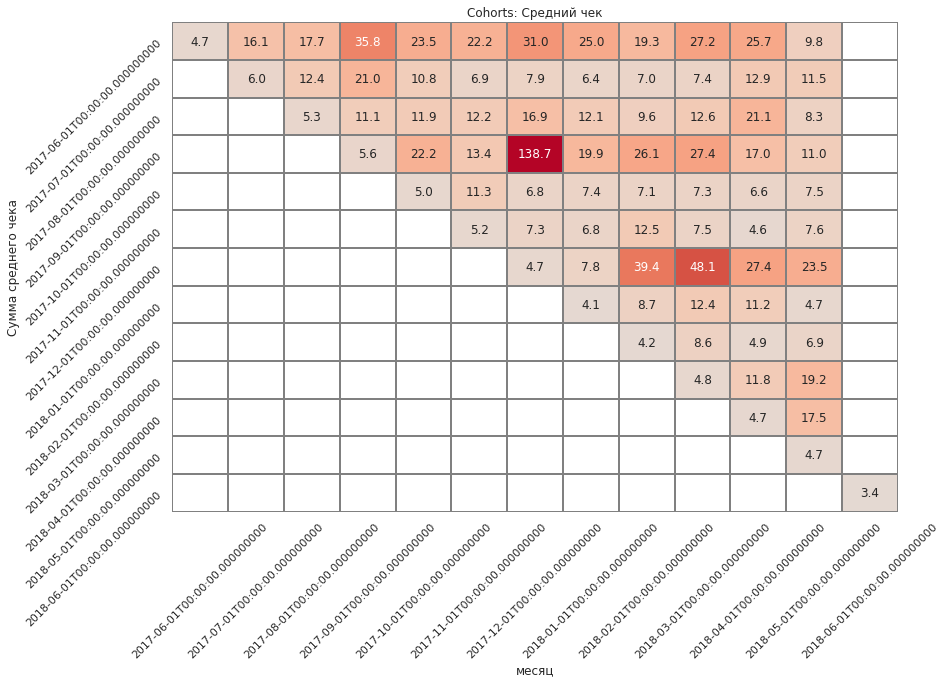

In [54]:
sns.set(style='white')
plt.figure(figsize=(13, 9))

sns.heatmap(orders_grouped_pivot \
                , annot=True \
                , fmt='.1f' \
                , linewidths=1 \
                , linecolor='gray' \
                , cmap="coolwarm" \
                , vmin=0 \
                , vmax=60 \
                , center= 0 \
                , cbar=False);

plt.title('Cohorts: Средний чек');
plt.xlabel("месяц");
plt.ylabel("Сумма среднего чека");
plt.yticks(rotation=45);
plt.xticks(rotation=45);

ДОБАВЛЕН РАСЧЕТ СРЕДНЕГО ЧЕКА ПО ВСЕМУ ДАТА СЕТУ: сложим количество позиций во всех чеках за период и разделиим на количество  чеков

In [55]:
check_mean = orders_log['revenue'].sum()/orders_log.shape[0]
print("Средний чек: {:.4f}".format(check_mean))

Средний чек: 4.9996


### Расчет LTV
<a id="LTV"></a>

Будем считать LTV = прибыль /  количество покупок


In [56]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['date'] = pd.to_datetime(costs['dt'])

orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
costs['month'] = costs['date'].astype('datetime64[M]')

first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
# месяц первого заказа в датафрейм к покупкам
orders_first_month = pd.merge(orders,first_orders, on = 'uid')
# заказы по гокортам
cohorts = orders_first_month \
                .groupby(['first_order_month','order_month']) \
                .agg({'revenue': 'sum'}) \
                .reset_index()
# объедяем
report = pd.merge(cohort_sizes,cohorts, on = 'first_order_month')
# возраст каждой когорты в месяцах 
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
# LTV когорт
report['ltv'] = report['revenue'] / report['n_buyers']

report_result = report

result = report.pivot_table( \
                            index='first_order_month', \
                            columns='age', \
                            values='ltv', \
                            aggfunc='mean') \
                            .round(2) \
                            .fillna('')

In [57]:
result

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


расчет среднего LTV за период 6 месяцев

In [58]:
monthly_costs = costs.groupby('month').sum()
report_ltv = pd.merge( \
                      report \
                      ,monthly_costs \
                      ,left_on='first_order_month' \
                      ,right_on='month')
final_result = report_ltv.pivot_table( \
                                      index='first_order_month' \
                                      ,columns='age' \
                                      ,values='ltv' \
                                      ,aggfunc='mean')
m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5] 
print('Средний LTV за 6 месяцев: {:.2f}'.format(m6_cum_ltv))

Средний LTV за 6 месяцев: 7.97


Вложения на рекламу должны быть меньше чем 7.97, чтобы не прогореть.


# Расчет маркетиговых показателей
   <a id="marketing"></a>
   
## Расчет потраченных денег
   <a id="pursch"></a>

In [59]:
monthly_costs = costs.groupby('month').sum()
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

final_result = report_new.pivot_table( index='first_order_month', columns='age', values='ltv', aggfunc='mean')


## Стоимость привлечения покупателя


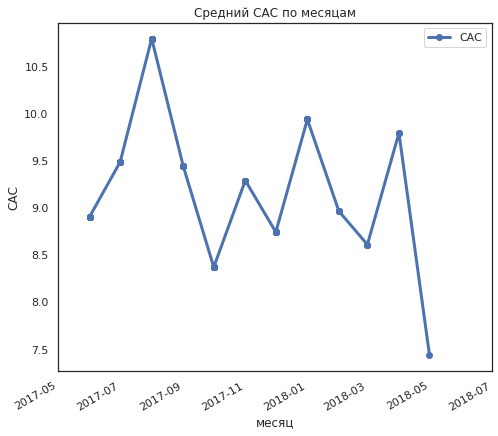

In [60]:
report_new.plot( \
                x='first_order_month' \
                , y='cac' \
                ,figsize=(7, 6) \
                ,marker = 'o' \
                ,linewidth = 3 \
                ,xlim=('2017-05-01', '2018-07-01')
                );
                
plt.tight_layout();
plt.title("Средний CAC по месяцам");
plt.legend(["CAC"]);
plt.xlabel("месяц");
plt.ylabel("CAC");

 расчет CAC затрат по источникам привлечения клиента 

In [61]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table( \
                                index='first_order_month' \
                                ,columns='age' \
                                ,values='romi' \
                                ,aggfunc='mean')

In [62]:
output.cumsum(axis=1).round(2).fillna('') 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


## Расчет ROI
<a id="ROI"></a>

ROI  получим как (ДОХОД - РАСХОД)/ РАСХОД * 100

In [63]:
monthly_costs_per = costs.groupby('month', as_index=False).sum()
orders_log['month'] = orders_log['buy_ts'].astype('datetime64[M]')
monthly_order_per = orders_log.groupby('month', as_index=False).sum() 

n_buyers = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
report_per = pd.merge(monthly_order_per, monthly_costs_per, on='month')
report_per['roi'] = (monthly_order_per['revenue'] - monthly_costs_per['costs']) \
                            / monthly_costs_per['costs'] * 100

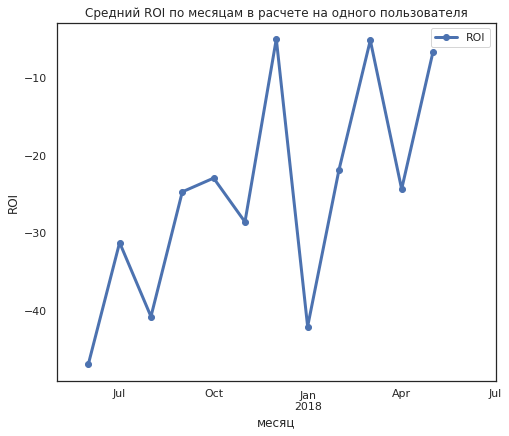

In [64]:
report_per.plot( \
                x='month' \
                , y='roi' \
                ,figsize=(7, 6) \
                ,marker = 'o' \
                ,linewidth = 3 \
                ,xlim=('2017-05-01', '2018-07-01')
                );
                
plt.tight_layout();
plt.title("Средний ROI по месяцам в расчете на одного пользователя");
plt.legend(["ROI"]);
plt.xlabel("месяц");
plt.ylabel("ROI");

Добавлен расчет затрат на привлечение клиента, ROI и CAC в зависимости от источника привлечения клиента 

Выделим из даты год и месяц покупок и затрат на привлечение. 

In [65]:
costs['month_yr'] = costs['date'].apply(lambda x: x.strftime('%B-%Y')) 
orders_log['month_yr'] = orders_log['buy_ts'].apply(lambda x: x.strftime('%B-%Y'))
visits_log['month_yr'] = visits_log['start_ts'].apply(lambda x: x.strftime('%B-%Y'))

соединим в одну таблицу покупки. затраты на рекламу и построим графики

In [66]:
first_visit = visits_log.groupby('uid')['start_ts'].min()
first_visit.name = 'first_visit'
visits_log = visits_log.join(first_visit,on='uid')

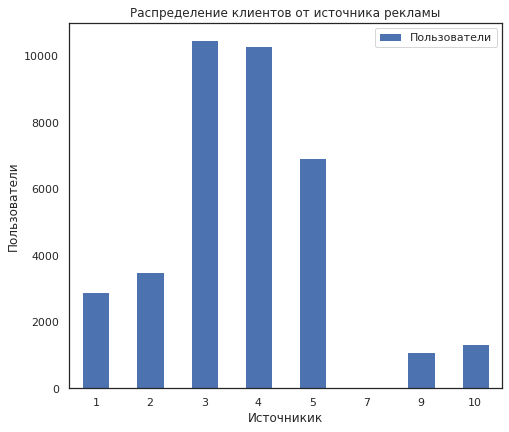

In [67]:
visits_by_source = visits_log.query('start_ts == first_visit')
customers_by_source = (orders_log.merge(visits_by_source, on='uid', how='inner'))\
                        .groupby('source_id').agg({'uid':'nunique'})\
                        .rename(columns={'uid':'customers'})
customers_by_source.plot( kind='bar'\
                ,figsize=(7, 6) )

plt.tight_layout();
plt.title("Распределение клиентов от источника рекламы");
plt.legend(["Пользователи"]);
plt.xlabel("Источникик");
plt.ylabel("Пользователи");
plt.xticks(rotation=0);

видно, что основную долю пользователей составляют пользователи, привлеченные по каналам 3,4. Учитывая что привлечение клиента обходится дороже удержания, стоит обратить внимание на эти каналы

In [68]:
visits_by_source = visits_log.query('start_ts == first_visit')
customers_by_source = (orders_log.merge(visits_by_source, on='uid', how='inner'))\
                        .groupby('source_id').agg({'uid':'nunique'})\
                        .rename(columns={'uid':'customers'})

revenue_by_source = (orders_log.merge( \
                                visits_by_source \
                                , on='uid' \
                                , how='inner'))

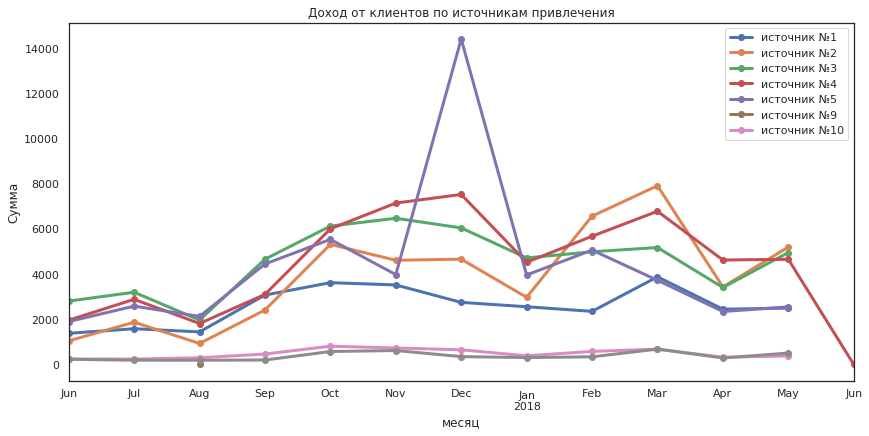

In [69]:
revenue_by_source.pivot_table( \
                    index='month' \
                    ,columns='source_id' \
                    ,values='revenue' \
                    ,aggfunc='sum').plot(\
                                         figsize=(12, 6) \
                                         ,marker = 'o' \
                                         ,linewidth = 3);

plt.tight_layout();
plt.title("Доход от клиентов по источникам привлечения");
plt.legend(["источник №1", "источник №2", "источник №3", "источник №4", \
            "источник №5", "источник №9", "источник №10"]);
plt.xlabel("месяц");
plt.ylabel("Сумма");


Учитывая число привлекаемых пользователей по каналам 3,4 можно порекомедовать вкладываться в привлечение по каналу 2, средний доход от привлечения примерно одинаков, несмотря на существенно меньшее число пользователей 

In [70]:
costs['month'] = costs['month'].astype(object)

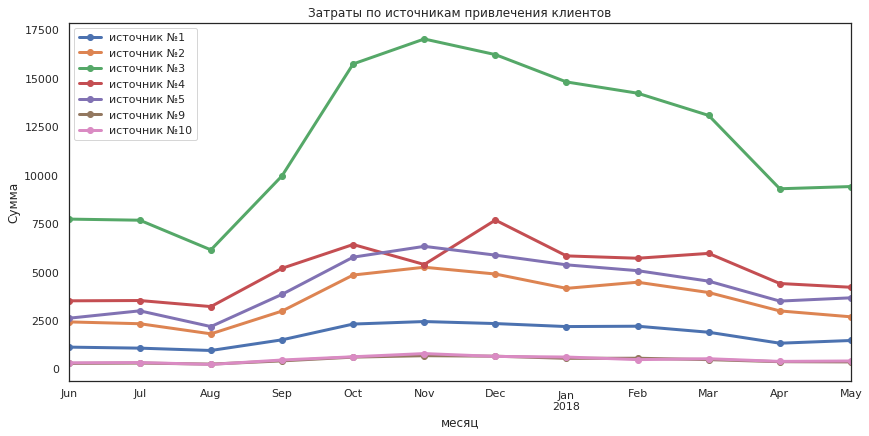

In [71]:
costs.pivot_table( \
                    index='month' \
                    ,columns='source_id' \
                    ,values='costs' \
                    ,aggfunc='sum').plot(\
                                         figsize=(12, 6) \
                                         ,marker = 'o' \
                                         ,linewidth = 3);

plt.tight_layout();
plt.title("Затраты по источникам привлечения клиентов");
plt.legend(["источник №1", "источник №2", "источник №3", "источник №4", \
            "источник №5", "источник №9", "источник №10"]);
plt.xlabel("месяц");
plt.ylabel("Сумма");


Самые высокие суммарные затраты на привления клиентов по каналу 3, по каналу 9,10 минимальные. Пик затрат приходится на ноябрь 2017. Канал 3 приносит пользователей сопоставимо с каналом 4, а затраты не сопоставимы. Можно рекоментовать не использовать 3 канал, а направить инвестиции в привлечение по каналу 2, как перспективного. Данные рассуждения верны без учета ROI

Проагрегируем revenue  и costs  по источникам и объединим для рассчета cac и romi

###### Соединим две таблицы в одну - расходы и доходы по источникам в зависимости от месяца

In [72]:
report = (orders_log.merge(visits_by_source, on='uid', how='inner'))
revenue = report.groupby(['source_id', 'first_activity_date']).agg({'revenue':'sum'}).reset_index()
revenue.rename(columns={'first_activity_date':'month'}, inplace=True)
revenue.sample(3)

,source_id,month,revenue
22,2,2018-04-01,1101.38
56,5,2018-02-01,2735.62
7,1,2018-01-01,1034.83


In [73]:
costs_sum = costs.groupby(['source_id', 'month']).agg({'costs':'sum'}).reset_index()
costs_sum.sample(3)

,source_id,month,costs
7,1,2018-01-01,2186.18
39,4,2017-09-01,5192.26
50,5,2017-08-01,2185.28


Соерем все в одну таблицу и проерим , что баланс бъется

In [74]:
report = revenue.merge(costs_sum, on=['source_id', 'month'], how='inner')
report[:3]


,source_id,month,revenue,costs
0,1,2017-06-01,9910.69,1125.61
1,1,2017-07-01,2341.21,1072.88
2,1,2017-08-01,2624.27,951.81


Расчет ROI

In [76]:
report['roi'] = (report['revenue'] - report['costs']) / report['costs']

In [77]:
cust_by_src = (orders_log.merge(visits_by_source, on='uid', how='inner'))\
                        .groupby(['source_id','first_activity_date']).agg({'uid':'nunique'})\
                        .rename(columns={'uid':'n_buyers'}).reset_index()
cust_by_src.rename(columns={'first_activity_date':'month'}, inplace=True)

In [78]:
report = report.merge(cust_by_src, on=['source_id', 'month'], how='inner')
report[:1]

,source_id,month,revenue,costs,roi,n_buyers
0,1,2017-06-01,9910.69,1125.61,7.804728,240


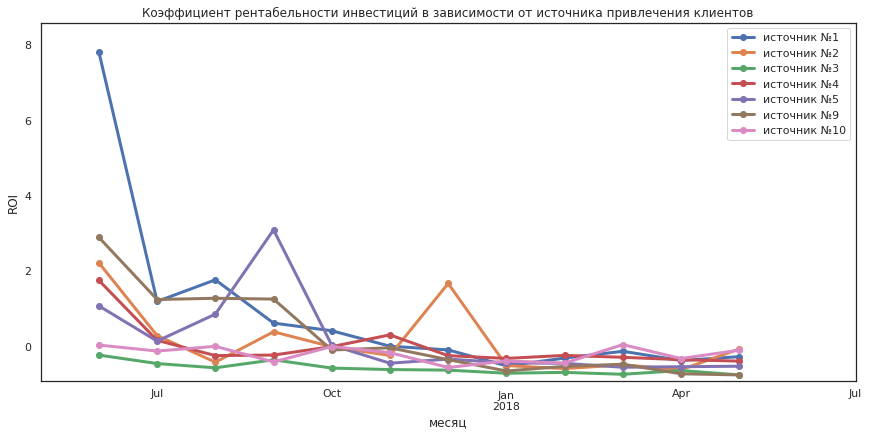

In [79]:
report.pivot_table( \
                    index='month' \
                    ,columns='source_id' \
                    ,values='roi').plot(\
                                        figsize=(12, 6) \
                                        ,marker = 'o' \
                                        ,linewidth = 3 \
                                        ,ylim=(1.2*report['roi'].min(), 1.1*report['roi'].max()) \
                                        ,xlim=('2017-05-01', '2018-07-01'));

plt.tight_layout();
plt.title("Коэффициент рентабельности инвестиций в зависимости от источника привлечения клиентов");
plt.legend(["источник №1", "источник №2", "источник №3", "источник №4", \
            "источник №5", "источник №9", "источник №10"]);
plt.xlabel("месяц");
plt.ylabel("ROI");


Ориентируюясь на ROI можно сделать вывод, что затраты на инвестиции в рекламу канала №1 и 9 окупаются очень быстро и стоит уделить внимание на удержание и привлечение клиентов по этому каналу рекламы. 

LTV, CAC по источникам привлечения клиентов

In [80]:
report['ltv'] = report['revenue'] / report['n_buyers']
report['cac'] = report['costs'] / report['n_buyers']
report['romi'] = report['ltv'] / report['cac'] 
report[:3]

,source_id,month,revenue,costs,roi,n_buyers,ltv,cac,romi
0,1,2017-06-01,9910.69,1125.61,7.804728,240,41.294542,4.690042,8.804728
1,1,2017-07-01,2341.21,1072.88,1.182173,184,12.723967,5.830870,2.182173
2,1,2017-08-01,2624.27,951.81,1.757136,126,20.827540,7.554048,2.757136


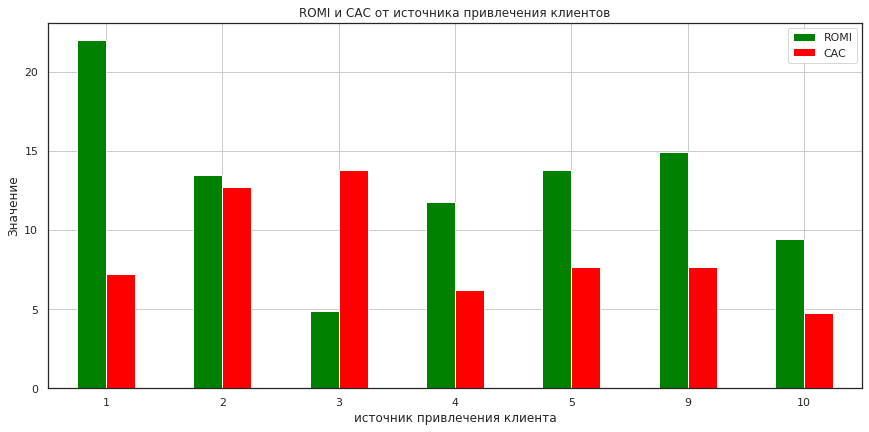

In [81]:
report.groupby('source_id').agg({'romi':'sum', 'cac':'mean'}) \
        .plot(kind='bar',figsize=(12, 6), grid=True, color=['green', 'red']);

plt.tight_layout();
plt.title("ROMI и САС от источника привлечения клиентов");
plt.legend(["ROMI", "CAC"]);
plt.xlabel("источник привлечения клиента");
plt.ylabel("Значение");              
plt.xticks(rotation=0);


Из графика видно, что канал №1 самый предпочтительный для вложений в рекламу для увеличиения клиентов. Доход от пользователей, привлеченных по этому каналу превышает затраты на привлечение в несколько раз. Канал №3 убыточен, несмотря на большое количество привлеченных клиентов. От вложений в рекламу канала №2 также следует воздержаться, доход незначительно превышает расходы. Возможно также стоит рассмотреть возможность отказа от каналов 9-10 как приносящих незначительную прибыль в абсолютном выражении.
